## CNN Cards
**Alumno:** Moises Britez Iglesia


### Estructura local
Configuración de la estructura local del proyecto para el desarrollo de modelos CNN para clasificación de cartas.
- Creación de carpetas para datos, modelos, y resultados. (#Datasets, #Models, #Results)
- Creación de un entorno virtual para gestionar dependencias. (#venv) si es necesario. En este caso se utilizara un contenedor Docker.

#### Para iniciar el contenedor Docker
```powershell
docker-compose up -d --build
```
#### Para acceder al contenedor Docker
```powershell
docker exec -it tf-gpu-jupyter bash
```
```bash
pip install -r requirements.txt

tensorboard --logdir=logs/
```
Se encuentra habilitado el puerto 8888 para Jupyter Notebook. 6006 para TensorBoard. Para acceder a tensorboard, abrir un navegador y dirigirse a http://localhost:6006

# Para detener el contenedor Docker
```powershell
docker-compose down
```

In [1]:
#verificamos directorios en el contenedor
!ls

CNN-Cards  archive		  checkpoints_scratch  logs_scratch
DL-HW-1    checkpoints_mobilenet  checkpoints_vgg16    prueba.ipynb
Labs	   checkpoints_resnet50   logs		       requirements.txt


In [ ]:
import os

# Configurar directorio de trabajo
target_dir = os.getcwd() if 'cnn-cards' in os.getcwd().lower() else './CNN-Cards'

if os.path.isdir(target_dir):
    os.chdir(target_dir)
print(f'Directorio actual: {os.getcwd()}')

Directorio actual: /tf/CNN-Cards


In [2]:
#Verificamos archivos en el directorio actual
print(os.listdir())
###
DATA_PATH = './Datasets/Cards/'


['01_finetune_vit.ipynb', '02_finetune_mobilenet.ipynb', '03_improve_custom_cnn.ipynb', '04_train_multioutput.ipynb', '05_ensemble.ipynb', '06_inference_pipeline.ipynb', 'Class_Cards.ipynb', 'Datasets', 'logs', 'Models', 'Results']


## Import libraries

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suprimir warnings de TensorFlow

import tensorflow as tf
from vit_keras import vit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Global variables
SIZE = 224    # Dimensions of the images
CLASSES = 53  # Number of categories
EPOCHS = 75
PATIENCE_ES = 20

path_models = 'Models'

2025-11-30 23:33:59.001627: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-30 23:33:59.001675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-30 23:33:59.002436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

In [4]:
!ls Models

Custom_3.h5  MobileNet.h5  MobileNet_2.h5  ViT_B16.h5  ViT_B16_2.h5


In [4]:
print(tf.__version__)

print(tf.test.gpu_device_name())

if tf.test.is_built_with_gpu_support():
    print('Se detectó una GPU')
else:
    print('No se detectó una GPU')

2.15.0
/device:GPU:0
Se detectó una GPU


In [6]:
!nvidia-smi

Sun Nov 30 23:11:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.51                 Driver Version: 555.97         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0             24W /  120W |    2198MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load pre-trained models

In [5]:
# Download pre-trained models without the Top
MobileNet = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(SIZE,SIZE,3))
vitB16 = vit.vit_b16(image_size= SIZE, include_top=False, pretrained_top=False, pretrained=True)

vitB16.trainable = False
MobileNet.trainable = False

/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [9]:
# Summary of the model
MobileNet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

API Sequential: Una forma sencilla y lineal de apilar capas.

Limitaciones:

*   No permite modelos con múltiples entradas o salidas
*  No admite capas compartidas o conexiones no lineales
*   No es adecuada para arquitecturas donde se necesitan saltos o conexiones entre capas no adyacentes.


API Funcional: Una forma más flexible que permite construir modelos complejos con arquitecturas personalizadas.

## Build model in Sequential API

In [10]:
# Build models based on the pre-trained with the Sequential API

# creation as a list of layers
mn_sq = tf.keras.Sequential([
    MobileNet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CLASSES, activation='softmax')
                                ])
transformer_sq = tf.keras.Sequential([
    vitB16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CLASSES, activation='softmax')
                                ])
# Creation by adding layers
model_sq = tf.keras.Sequential()
model_sq.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
model_sq.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_sq.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_sq.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_sq.add(tf.keras.layers.Flatten())
model_sq.add(tf.keras.layers.Dense(128, activation='relu'))
model_sq.add(tf.keras.layers.Dense(64, activation='relu'))
model_sq.add(tf.keras.layers.Dense(CLASSES, activation='softmax'))

In [11]:
# Summary of the model
mn_sq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 53)                3445      
                                                                 
Total params: 10297973 (39.28 MB)
Trainable params: 8039989 (30.67 MB)
Non-trainable params: 2257984 (8.61 MB)
___________

In [12]:
# Summary of the model
transformer_sq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               98432     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 53)                3445      
                                                                 
Total params: 85908789 (327.72 MB)
Trainable params: 110133 (430.21 KB)
Non-trainable params: 85798656 (327.30 MB)
_________________________________________________________________


In [13]:
# Summary of the model
model_sq.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_6 (Dense)             (None, 128)              

## Build model in Functional API

In [14]:
# Build models based on the pre-trained with the Functional API

inputy = tf.keras.layers.Input(shape=(SIZE,SIZE,3))
y = MobileNet(inputy)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dense(128, activation='relu')(y)
y = tf.keras.layers.Dense(64, activation='relu')(y)
outputy = tf.keras.layers.Dense(CLASSES, activation='softmax')(y)

mn_fc = tf.keras.Model(inputs=inputy, outputs=outputy)

#########################################################################################

input = tf.keras.layers.Input(shape=(SIZE,SIZE,3))  # Declare input layer
x = vitB16(input)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(CLASSES, activation='softmax')(x)

transformer_fc = tf.keras.Model(inputs=input, outputs=output)  # Build the model

#########################################################################################

inputc = tf.keras.layers.Input(shape=(SIZE,SIZE,3))
y = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3))(inputc)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(y)
y = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(y)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(y)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dense(128, activation='relu')(y)
y = tf.keras.layers.Dense(64, activation='relu')(y)
outputc = tf.keras.layers.Dense(CLASSES, activation='softmax')(y)

model_fc = tf.keras.Model(inputs=inputc, outputs=outputc)

In [15]:
# Summary of the model
mn_fc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               8028288   
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 53)                3445      
                                                             

## Compare models

In [16]:
# Number of parameters comparision
# Convolutional transfer learning
trainable_params_cfc = np.sum([np.prod(variable.shape) for variable in mn_fc.trainable_variables])
non_trainable_params_cfc = np.sum([np.prod(variable.shape) for variable in mn_fc.non_trainable_variables])

trainable_params_csq = np.sum([np.prod(variable.shape) for variable in mn_sq.trainable_variables])
non_trainable_params_csq = np.sum([np.prod(variable.shape) for variable in mn_sq.non_trainable_variables])

if (trainable_params_cfc == trainable_params_csq) and (non_trainable_params_cfc==non_trainable_params_csq):
  print('MobileNet model OK')

# Transformer architecture
trainable_params_tfc = np.sum([np.prod(variable.shape) for variable in transformer_fc.trainable_variables])
non_trainable_params_tfc = np.sum([np.prod(variable.shape) for variable in transformer_fc.non_trainable_variables])

trainable_params_tsq = np.sum([np.prod(variable.shape) for variable in transformer_sq.trainable_variables])
non_trainable_params_tsq = np.sum([np.prod(variable.shape) for variable in transformer_sq.non_trainable_variables])

if (trainable_params_tfc == trainable_params_tsq) and (non_trainable_params_tfc==non_trainable_params_tsq):
  print('Transformer model OK')

# Custom convolutional model
trainable_params_customfc = np.sum([np.prod(variable.shape) for variable in model_fc.trainable_variables])
non_trainable_params_customfc = np.sum([np.prod(variable.shape) for variable in model_fc.non_trainable_variables])

trainable_params_customsq = np.sum([np.prod(variable.shape) for variable in model_sq.trainable_variables])
non_trainable_params_customsq = np.sum([np.prod(variable.shape) for variable in model_sq.non_trainable_variables])

if (trainable_params_customfc == trainable_params_customsq) and (non_trainable_params_customfc==non_trainable_params_customsq):
  print('Convolutional model OK')

MobileNet model OK
Transformer model OK
Convolutional model OK


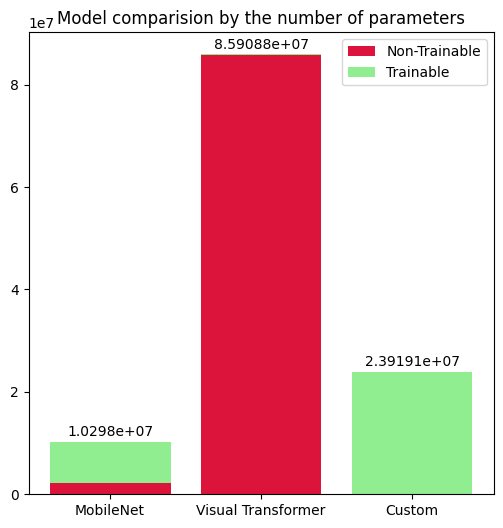

In [17]:
fig = plt.figure(figsize=(6,6))

axis_x = ['MobileNet', 'Visual Transformer', 'Custom']

ax = plt.subplot(1, 1, 1)
ax.bar(axis_x, [non_trainable_params_cfc, non_trainable_params_tfc, non_trainable_params_customfc], color='crimson', label='Non-Trainable')
b = ax.bar(axis_x, [trainable_params_cfc, trainable_params_tfc, trainable_params_customfc], bottom= [non_trainable_params_cfc, non_trainable_params_tfc, non_trainable_params_customfc], color='lightgreen', label='Trainable')
ax.bar_label(b, padding= 2)
ax.set_title('Model comparision by the number of parameters')
ax.legend(loc = 'upper right')
plt.show()

Despite the overall size of the model, the Transformer-based architecture has a very low number of trainable parameters.

## Load data

### Image data generator

In [6]:
# Image generator from TensorFlow (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255,
                                                                  rotation_range=10,
                                                                  horizontal_flip=True)

valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)

### Flow from directory method

In [7]:
# Build the datasets with flow from directory method from ImageDataGenerator object

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

# Path to the directory
# Define sizes
# Declare classes as categorical
# Batch size = 16
# Train dataset should always have shuffle
train_dataset_ffd = train_generator.flow_from_directory(
    train_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= True
                                                        )

# Valid and Test dataset don't need to be shuffled
valid_dataset_ffd = valid_generator.flow_from_directory(
    valid_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

test_dataset_ffd = test_generator.flow_from_directory(
    test_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


## Train models

### MobileNet

In [20]:
# Callbacks definitions for training
# Save the best model at the end of each epoch (if is better than the saved one)
# Stop training if the model is not improving after 20 epochs

name = 'MobileNet'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch')

stop = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.01,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True)

In [21]:
# Model compilation
mn_sq.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
def plot_and_save(h, dir, name):

  history = pd.DataFrame(h.history)

  history['epoch'] = list(range(0,len(history.index)))

  history.to_csv(os.path.join(dir, name+'.csv'), header=True, index=False)

  # Plot history: CE
  plt.figure()
  plt.plot(history['epoch'], history['loss'], label='Loss (training data)')
  plt.plot(history['epoch'], history['val_loss'], label='Loss (validation data)')
  plt.title('Loss')
  plt.ylabel('CE')
  plt.xlabel('Nº epoch')
  plt.legend(loc="upper left")
  plt.show()

  # Plot history: Accuracy
  plt.figure()
  plt.plot(history['epoch'], history['accuracy'], label='Accuracy (training data)')
  plt.plot(history['epoch'], history['val_accuracy'], label='Accuracy (validation data)')
  plt.title('Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Nº epoch')
  plt.legend(loc="upper left")
  plt.show()

Toca abrir la ventana y que el frio de Donostia haga lo suyo.

In [23]:
EPOCHS = 25
h = mn_sq.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpoint, stop])

Epoch 1/25


I0000 00:00:1764511973.708082     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 [==============================] - ETA: 0s - loss: 3.3436 - accuracy: 0.2415

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 128s 1s/step - loss: 3.3436 - accuracy: 0.2415 - val_loss: 2.1140 - val_accuracy: 0.4453
Epoch 2/25
120/120 [==============================] - 61s 507ms/step - loss: 1.7853 - accuracy: 0.5176 - val_loss: 1.8702 - val_accuracy: 0.4981
Epoch 3/25
120/120 [==============================] - 60s 500ms/step - loss: 1.3781 - accuracy: 0.6086 - val_loss: 1.5719 - val_accuracy: 0.5849
Epoch 4/25
120/120 [==============================] - 56s 467ms/step - loss: 1.0954 - accuracy: 0.6813 - val_loss: 1.3494 - val_accuracy: 0.6075
Epoch 5/25
120/120 [==============================] - 60s 536ms/step - loss: 0.9142 - accuracy: 0.7303 - val_loss: 1.4484 - val_accuracy: 0.5396
Epoch 6/25
120/120 [==============================] - 59s 495ms/step - loss: 0.7834 - accuracy: 0.7672 - val_loss: 1.5536 - val_accuracy: 0.5962
Epoch 7/25
120/120 [==============================] - 61s 504ms/step - loss: 0.6832 - accuracy: 0.7834 - val_loss: 1.4588 - val_accuracy: 0.637

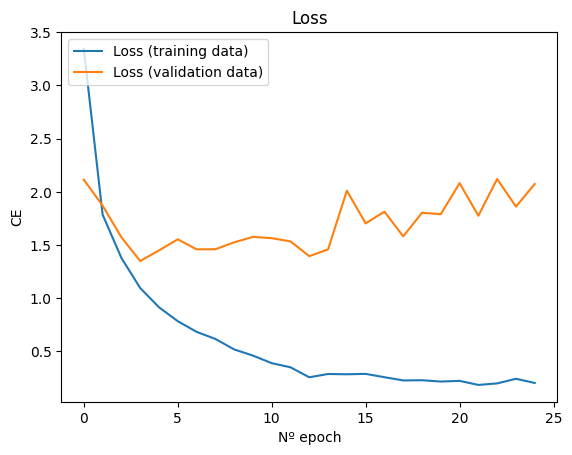

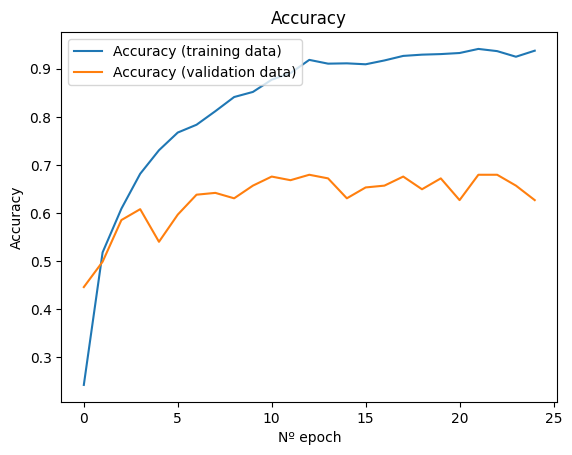

In [24]:
plot_and_save(h, 'Results', name)

This model is overfitted, data augmentation in training data is required

### Visual Transformer

In [31]:
# Callbacks definitions for training
# Save the best model at the end of each epoch (if is better than the saved one)
# Stop training if the model is not improving after 20 epochs

name = 'ViT_B16'

checkpointv = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch'
                                                )

stopv = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.01,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True
                                                )

In [32]:
# Model compilation
transformer_sq.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
h = transformer_sq.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpointv, stopv])

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 3.2366 - accuracy: 0.1388

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 88s 669ms/step - loss: 3.2366 - accuracy: 0.1388 - val_loss: 2.3959 - val_accuracy: 0.2415
Epoch 2/100
120/120 [==============================] - 72s 593ms/step - loss: 2.2792 - accuracy: 0.2955 - val_loss: 2.0766 - val_accuracy: 0.3057
Epoch 3/100
120/120 [==============================] - 75s 618ms/step - loss: 2.0014 - accuracy: 0.3667 - val_loss: 1.8299 - val_accuracy: 0.3774
Epoch 4/100
120/120 [==============================] - 78s 643ms/step - loss: 1.8151 - accuracy: 0.4250 - val_loss: 1.7111 - val_accuracy: 0.4151
Epoch 5/100
120/120 [==============================] - 75s 617ms/step - loss: 1.7000 - accuracy: 0.4647 - val_loss: 1.7083 - val_accuracy: 0.3849
Epoch 6/100
120/120 [==============================] - 76s 633ms/step - loss: 1.6202 - accuracy: 0.4890 - val_loss: 1.6806 - val_accuracy: 0.4000
Epoch 7/100
120/120 [==============================] - 80s 663ms/step - loss: 1.5239 - accuracy: 0.5054 - val_loss: 1.5802 - val_accurac

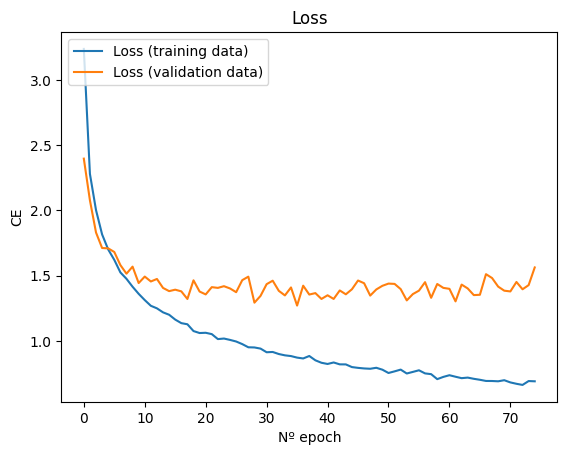

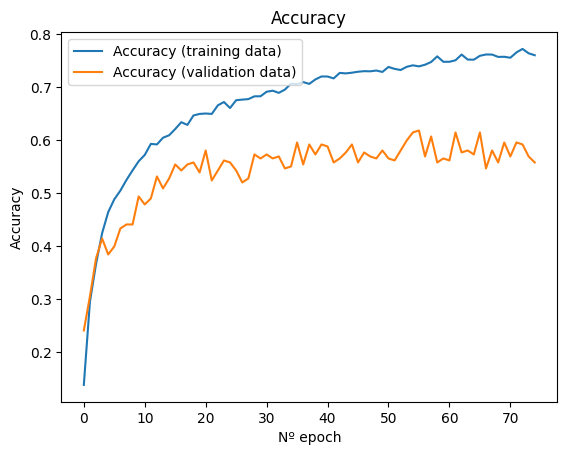

In [34]:
plot_and_save(h, 'Results', name)

This model is overfitted, and also needs more trainable parameters

### Custom

In [ ]:
# Compile the model
model_sq.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks definitions for training
# Save the best model at the end of each epoch (if is better than the saved one)
# Stop training if the model is not improving after 20 epochs

name = 'Custom'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch'
                                                )

stop = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.01,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True
                                                )

h = model_sq.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpoint, stop])

In [ ]:
plot_and_save(h, 'Results', name)

This model is overfitted

## Fine tuning train

### MobileNet, data augmentation in training data is implemented, number of trainable weights is higher

In [16]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255,
                                                                  rotation_range=15,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True,
                                                                  zoom_range=0.1,
                                                                  fill_mode='reflect')


valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

# Path to the directory
# Define sizes
# Declare classes as categorical
# Batch size = 16
# Train dataset should always have shuffle
train_dataset_ffd = train_generator.flow_from_directory(
    train_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= True
                                                        )

# Valid and Test dataset don't need to be shuffled
valid_dataset_ffd = valid_generator.flow_from_directory(
    valid_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

test_dataset_ffd = test_generator.flow_from_directory(
    test_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [44]:
name = 'MobileNet_2'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch'
                                                )

stop = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.001,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True
                                                )

In [19]:
mn_train_1 = tf.keras.models.load_model('Models/MobileNet.h5')
weights = mn_train_1.get_weights()

base_net = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(SIZE,SIZE,3))

# by default, layers are trainable
# MobileNet has 154 layers
# Freezing 130, rougthly 60% trainable parameters
for layer in base_net.layers[:130]:
    layer.trainable = False

mn_ft = tf.keras.Sequential([
    base_net,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CLASSES, activation='softmax')])

In [ ]:
EPOCHS=100
mn_ft.set_weights(weights)

mn_ft.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
h = mn_ft.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpoint, stop])


Epoch 1/100


I0000 00:00:1764530289.119976    1647 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 [==============================] - ETA: 0s - loss: 2.0909 - accuracy: 0.4697

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 137s 1s/step - loss: 2.0909 - accuracy: 0.4697 - val_loss: 8.6083 - val_accuracy: 0.3019
Epoch 2/100
120/120 [==============================] - 64s 530ms/step - loss: 1.3358 - accuracy: 0.6259 - val_loss: 15.8029 - val_accuracy: 0.1623
Epoch 3/100
120/120 [==============================] - 64s 532ms/step - loss: 1.1589 - accuracy: 0.6624 - val_loss: 16.7212 - val_accuracy: 0.1094
Epoch 4/100
120/120 [==============================] - 64s 527ms/step - loss: 0.9590 - accuracy: 0.7194 - val_loss: 12.2555 - val_accuracy: 0.0943
Epoch 5/100
120/120 [==============================] - 65s 539ms/step - loss: 0.8813 - accuracy: 0.7442 - val_loss: 10.0907 - val_accuracy: 0.1736
Epoch 6/100
120/120 [==============================] - 65s 543ms/step - loss: 0.7962 - accuracy: 0.7656 - val_loss: 12.2797 - val_accuracy: 0.1849
Epoch 7/100
120/120 [==============================] - 59s 495ms/step - loss: 0.7116 - accuracy: 0.7896 - val_loss: 10.6132 - val_acc

NameError: name 'plot_and_save' is not defined

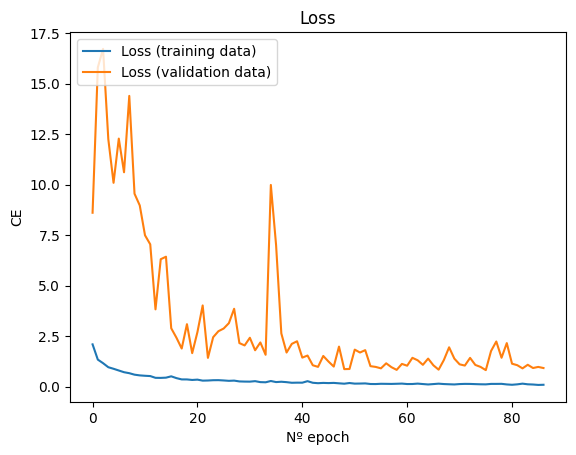

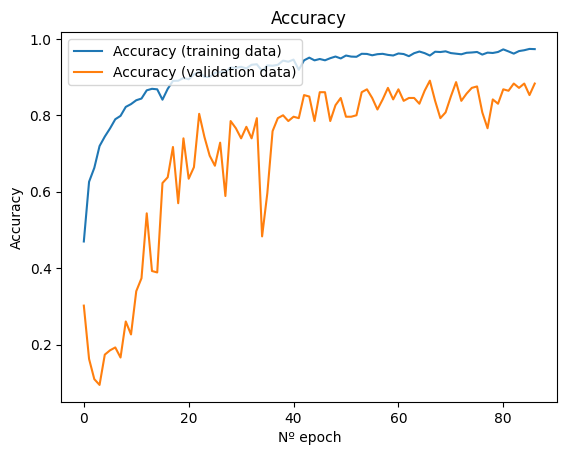

In [23]:
plot_and_save(h, 'Results', name)

### ViT, data augmentation in training is implemented, number of trainable weights is higher

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255,
                                                                  rotation_range=20,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True,
                                                                  zoom_range=0.1,
                                                                  fill_mode='reflect')


valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

# Path to the directory
# Define sizes
# Declare classes as categorical
# Batch size = 16 for ViT (GPU memory constraint)
# Train dataset should always have shuffle
train_dataset_ffd = train_generator.flow_from_directory(
    train_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 32,
    shuffle= True
                                                        )

# Valid and Test dataset don't need to be shuffled
valid_dataset_ffd = valid_generator.flow_from_directory(
    valid_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 32,
    shuffle= False
                                                        )

test_dataset_ffd = test_generator.flow_from_directory(
    test_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 32,
    shuffle= False
                                                        )

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [9]:
name = 'ViT_B16_2'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch'
                                                )

stop = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.001,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True
                                                )

In [10]:
# Recreate the same ViT-based architecture and load weights instead of loading the full saved model
# This avoids the Unknown layer error ('ClassToken') when loading a full model that uses custom layers.
transformer_train_1 = tf.keras.Sequential([
    vitB16,  # reused pre-initialized ViT backbone (defined earlier in the notebook)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CLASSES, activation='softmax')
])

weights_file = os.path.join(path_models, 'ViT_B16.h5')

try:
    # Try to load weights from the saved file (weights-only load)
    transformer_train_1.load_weights(weights_file)
    weights = transformer_train_1.get_weights()
except Exception as e:
    # Fallback: attempt to load full model providing custom_objects taken from vit module
    # This maps custom layer/classes used by vit_keras (e.g. ClassToken) so load_model can deserialize.
    custom_objs = {name: getattr(vit, name) for name in dir(vit) if not name.startswith('_')}
    transformer_train_1 = tf.keras.models.load_model(weights_file, custom_objects=custom_objs, compile=False)
    weights = transformer_train_1.get_weights()

# the pretrained is similar to weigths="imagenet"
base_net = vit.vit_b16(image_size= SIZE, include_top=False, pretrained_top=False, pretrained=True)

# by default, layers are trainable
# ViT has 19 layers
# Freezing 10, rougthly 60% trainable parameters
for layer in base_net.layers[:10]:
    layer.trainable = False

transformer_ft = tf.keras.Sequential([
    base_net,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CLASSES, activation='softmax')])

In [ ]:
transformer_ft.set_weights(weights)

# Evaluar accuracy inicial ANTES de entrenar
transformer_ft.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print('Evaluando accuracy inicial con pesos de ViT_B16.h5...')
_, initial_acc = transformer_ft.evaluate(test_dataset_ffd, verbose=0)
print(f'Accuracy inicial (con pesos cargados): {initial_acc:.4f}')

# Entrenar
print('\nIniciando fine-tuning...')
h = transformer_ft.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpoint, stop])

# Evaluar accuracy final
print('\nEvaluando accuracy final...')
_, final_acc = transformer_ft.evaluate(test_dataset_ffd, verbose=0)
print(f'\n=== Comparacion de resultados ===')
print(f'Accuracy inicial: {initial_acc:.4f}')
print(f'Accuracy final:   {final_acc:.4f}')
print(f'Mejora: {(final_acc - initial_acc)*100:.2f}%')


Evaluando accuracy inicial con pesos de ViT_B16.h5...
Accuracy inicial (con pesos cargados): 0.5623

Iniciando fine-tuning...
Accuracy inicial (con pesos cargados): 0.5623

Iniciando fine-tuning...
Epoch 1/75
Epoch 1/75


I0000 00:00:1764545744.071825     371 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


239/239 [==============================] - ETA: 0s - loss: 1.9898 - accuracy: 0.4373

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


239/239 [==============================] - 167s 622ms/step - loss: 1.9898 - accuracy: 0.4373 - val_loss: 0.6336 - val_accuracy: 0.7472
Epoch 2/75
Epoch 2/75
239/239 [==============================] - 159s 662ms/step - loss: 0.9152 - accuracy: 0.7041 - val_loss: 0.8057 - val_accuracy: 0.7698
Epoch 3/75
239/239 [==============================] - 159s 662ms/step - loss: 0.9152 - accuracy: 0.7041 - val_loss: 0.8057 - val_accuracy: 0.7698
Epoch 3/75
239/239 [==============================] - 163s 683ms/step - loss: 0.7541 - accuracy: 0.7643 - val_loss: 0.2548 - val_accuracy: 0.9208
Epoch 4/75
239/239 [==============================] - 163s 683ms/step - loss: 0.7541 - accuracy: 0.7643 - val_loss: 0.2548 - val_accuracy: 0.9208
Epoch 4/75
239/239 [==============================] - 159s 664ms/step - loss: 0.6373 - accuracy: 0.7963 - val_loss: 0.2874 - val_accuracy: 0.8981
Epoch 5/75
239/239 [==============================] - 159s 664ms/step - loss: 0.6373 - accuracy: 0.7963 - val_loss: 0.2874 -

NameError: name 'plot_and_save' is not defined

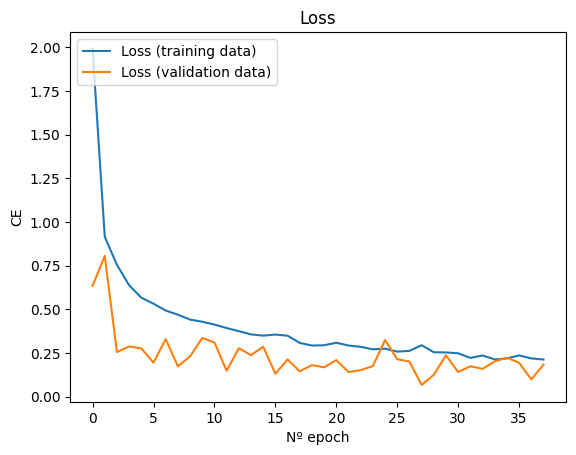

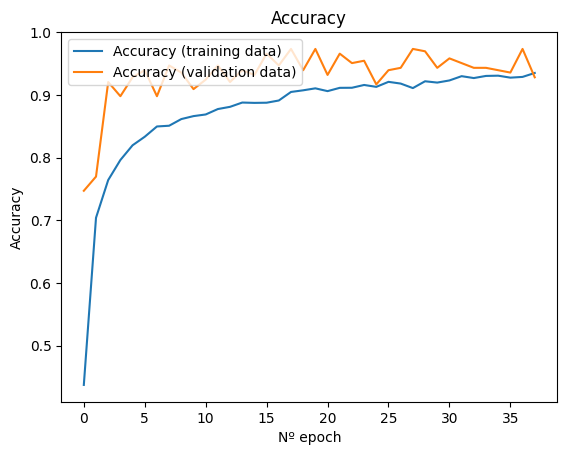

In [13]:

plot_and_save(h, 'Results', name)

### Custom, data augmentation in training is implemented

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255,
                                                                  rotation_range=15,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True,
                                                                  zoom_range=0.1,
                                                                  fill_mode='reflect')


valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

# Path to the directory
# Define sizes
# Declare classes as categorical
# Batch size = 16
# Train dataset should always have shuffle
train_dataset_ffd = train_generator.flow_from_directory(
    train_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= True
                                                        )

# Valid and Test dataset don't need to be shuffled
valid_dataset_ffd = valid_generator.flow_from_directory(
    valid_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

test_dataset_ffd = test_generator.flow_from_directory(
    test_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [ ]:
name = 'Custom_2'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch'
                                                )

stop = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.001,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True
                                                )

In [ ]:
model_ft = tf.keras.models.load_model('Models/Custom.h5')

Epoch 1/100
477/477 [==============================] - 54s 113ms/step - loss: 1.3178 - accuracy: 0.6898 - val_loss: 1.1278 - val_accuracy: 0.7358
Epoch 2/100
477/477 [==============================] - 52s 108ms/step - loss: 1.0721 - accuracy: 0.7331 - val_loss: 1.2688 - val_accuracy: 0.6717
Epoch 3/100
477/477 [==============================] - 50s 106ms/step - loss: 1.0038 - accuracy: 0.7385 - val_loss: 1.1837 - val_accuracy: 0.6906
Epoch 4/100
477/477 [==============================] - 50s 105ms/step - loss: 0.9338 - accuracy: 0.7559 - val_loss: 1.0779 - val_accuracy: 0.7170
Epoch 5/100
477/477 [==============================] - 50s 105ms/step - loss: 0.8294 - accuracy: 0.7808 - val_loss: 0.9664 - val_accuracy: 0.7660
Epoch 6/100
477/477 [==============================] - 49s 103ms/step - loss: 0.7988 - accuracy: 0.7828 - val_loss: 1.0575 - val_accuracy: 0.7547
Epoch 7/100
477/477 [==============================] - 49s 103ms/step - loss: 0.7735 - accuracy: 0.7891 - val_loss: 1.1237 -

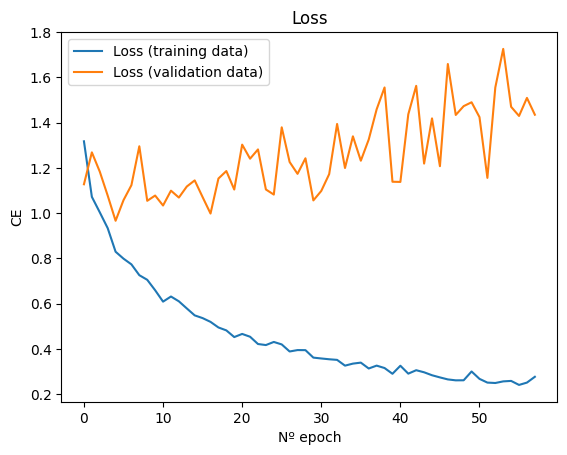

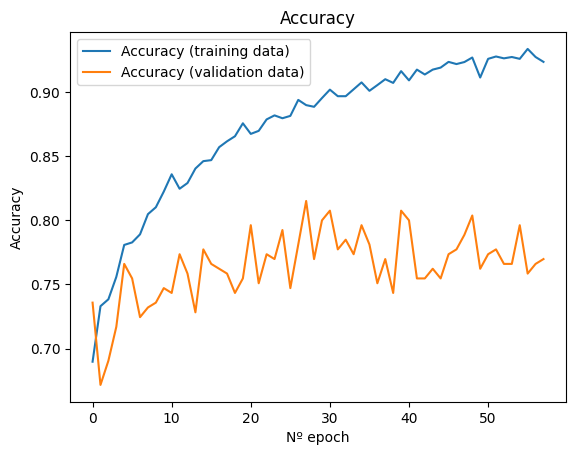

In [ ]:
model_ft.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
h = model_ft.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpoint, stop])

plot_and_save(h, path_csv, name)

#### STILL OVERFITTED, RE-TRAIN WITH MORE DATA AUGMENTATION

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255,
                                                                  rotation_range=10,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True,
                                                                  zoom_range=0.1,
                                                                  fill_mode='reflect',
                                                                  width_shift_range=0.1,
                                                                  shear_range=0.1,
                                                                  brightness_range=(0.95,1.05))


valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

# Path to the directory
# Define sizes
# Declare classes as categorical
# Batch size = 16
# Train dataset should always have shuffle
train_dataset_ffd = train_generator.flow_from_directory(
    train_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= True
                                                        )

# Valid and Test dataset don't need to be shuffled
valid_dataset_ffd = valid_generator.flow_from_directory(
    valid_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                        )

test_dataset_ffd = test_generator.flow_from_directory(
    test_path,
    target_size= (SIZE,SIZE),
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= False
                                                    )

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [ ]:
name = 'Custom_3'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor= 'val_accuracy',
    verbose= 0,
    save_best_only= True,
    save_weights_only= False,
    mode= 'max',
    save_freq= 'epoch'
                                                )

stop = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',
    min_delta= 0.001,
    patience= PATIENCE_ES,
    verbose = 0,
    mode= 'max',
    baseline= None,
    restore_best_weights= True
                                                )

Epoch 1/100
477/477 [==============================] - 57s 118ms/step - loss: 1.3143 - accuracy: 0.6448 - val_loss: 1.3756 - val_accuracy: 0.6679
Epoch 2/100
477/477 [==============================] - 57s 119ms/step - loss: 1.1496 - accuracy: 0.6822 - val_loss: 1.1428 - val_accuracy: 0.7434
Epoch 3/100
477/477 [==============================] - 56s 117ms/step - loss: 1.0851 - accuracy: 0.7041 - val_loss: 1.1626 - val_accuracy: 0.6868
Epoch 4/100
477/477 [==============================] - 56s 117ms/step - loss: 1.0068 - accuracy: 0.7171 - val_loss: 1.1420 - val_accuracy: 0.7019
Epoch 5/100
477/477 [==============================] - 56s 118ms/step - loss: 0.9591 - accuracy: 0.7291 - val_loss: 1.1858 - val_accuracy: 0.7132
Epoch 6/100
477/477 [==============================] - 56s 117ms/step - loss: 0.9434 - accuracy: 0.7301 - val_loss: 1.2219 - val_accuracy: 0.7245
Epoch 7/100
477/477 [==============================] - 56s 117ms/step - loss: 0.9087 - accuracy: 0.7390 - val_loss: 1.0753 -

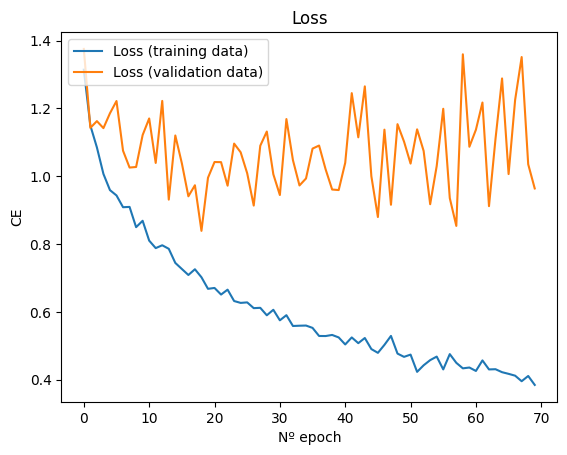

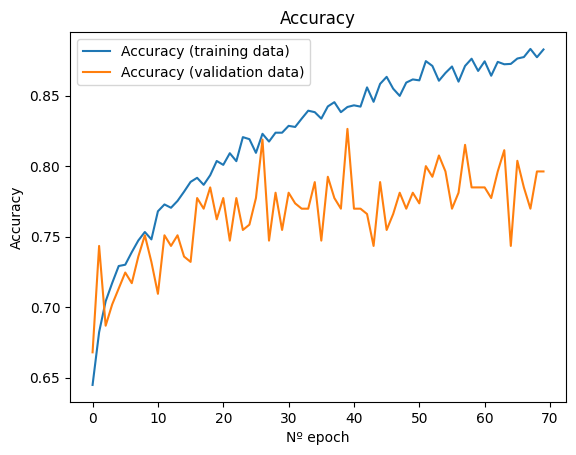

In [ ]:
model_ft2 = tf.keras.models.load_model('Models/Custom_2.h5')
model_ft2.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
h = model_ft2.fit(train_dataset_ffd, validation_data=valid_dataset_ffd, epochs=EPOCHS, callbacks=[checkpoint, stop])

plot_and_save(h, path_csv, name)

## Evaluation of fine tuning

In [ ]:
custom2 = tf.keras.models.load_model('Cards/Custom_2.h5')
custom3 = tf.keras.models.load_model('Models/Custom_3.h5')
transf2 = tf.keras.models.load_model('Models/ViT_B16_2.h5')
conv2 = tf.keras.models.load_model('Models/MobileNet_2.h5')

In [ ]:
_, conv_acc2 = conv2.evaluate(test_dataset_ffd)
_, transf_acc2 = transf2.evaluate(test_dataset_ffd)
_, custom_acc2 = custom2.evaluate(test_dataset_ffd)
_, custom_acc3 = custom3.evaluate(test_dataset_ffd)

17/17 [==============================] - 0s 18ms/step - loss: 1.6618 - accuracy: 0.7509


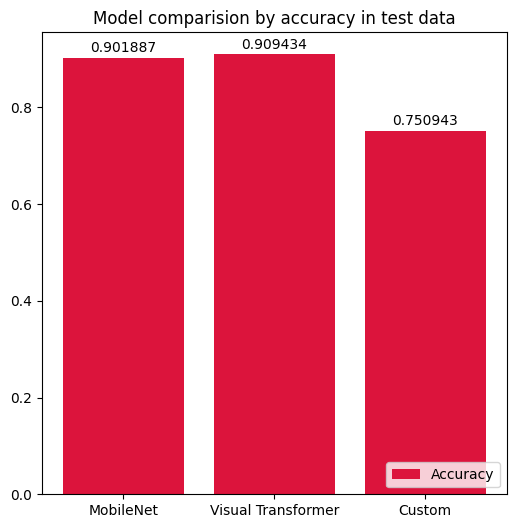

In [ ]:
fig = plt.figure(figsize=(6,6))

axis_x = ['MobileNet', 'Visual Transformer', 'Custom']

b = plt.bar(axis_x, [conv_acc2, transf_acc2, custom_acc3], color='crimson', label='Accuracy')
plt.bar_label(b, padding= 2)
plt.title('Model comparision by accuracy in test data')
plt.legend(loc = 'lower right')
plt.show()

### Classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def show_report(model, dataframe):

  labels = dataframe.class_indices

  true_labels = dataframe.labels
  pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)

  keys_array = np.array(list(labels.keys()))

  true_text = [keys_array[value] for value in true_labels]
  pred_text = [keys_array[value] for value in pred_labels]

  print(classification_report(true_text, pred_text))


def show_matrix(model, dataframe):

  labels = dataframe.class_indices

  true_labels = dataframe.labels
  pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)

  keys_array = np.array(list(labels.keys()))

  true_text = [keys_array[value] for value in true_labels]
  pred_text = [keys_array[value] for value in pred_labels]

  cf = confusion_matrix(true_text, pred_text, labels= keys_array)

  fig, ax = plt.subplots(figsize=(12,12))
  sns.heatmap(cf, annot=True, fmt="", square=True, cbar=False,
              cmap=plt.cm.Blues, xticklabels=keys_array, yticklabels=keys_array, ax = ax)
  ax.set_ylabel('Actual')
  ax.set_xlabel('Predicted')
  ax.set_title('Confusion Matrix')
  plt.show()

In [ ]:
show_report(transf2, test_dataset_ffd)

                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       1.00      1.00      1.00         5
    ace of spades       0.83      1.00      0.91         5
   eight of clubs       0.83      1.00      0.91         5
eight of diamonds       1.00      1.00      1.00         5
  eight of hearts       0.83      1.00      0.91         5
  eight of spades       0.83      1.00      0.91         5
    five of clubs       0.67      0.80      0.73         5
 five of diamonds       0.80      0.80      0.80         5
   five of hearts       0.83      1.00      0.91         5
   five of spades       0.83      1.00      0.91         5
    four of clubs       1.00      0.80      0.89         5
 four of diamonds       1.00      1.00      1.00         5
   four of hearts       1.00      1.00      1.00         5
   four of spades       1.00      0.80      0.89       

### Conf matrix

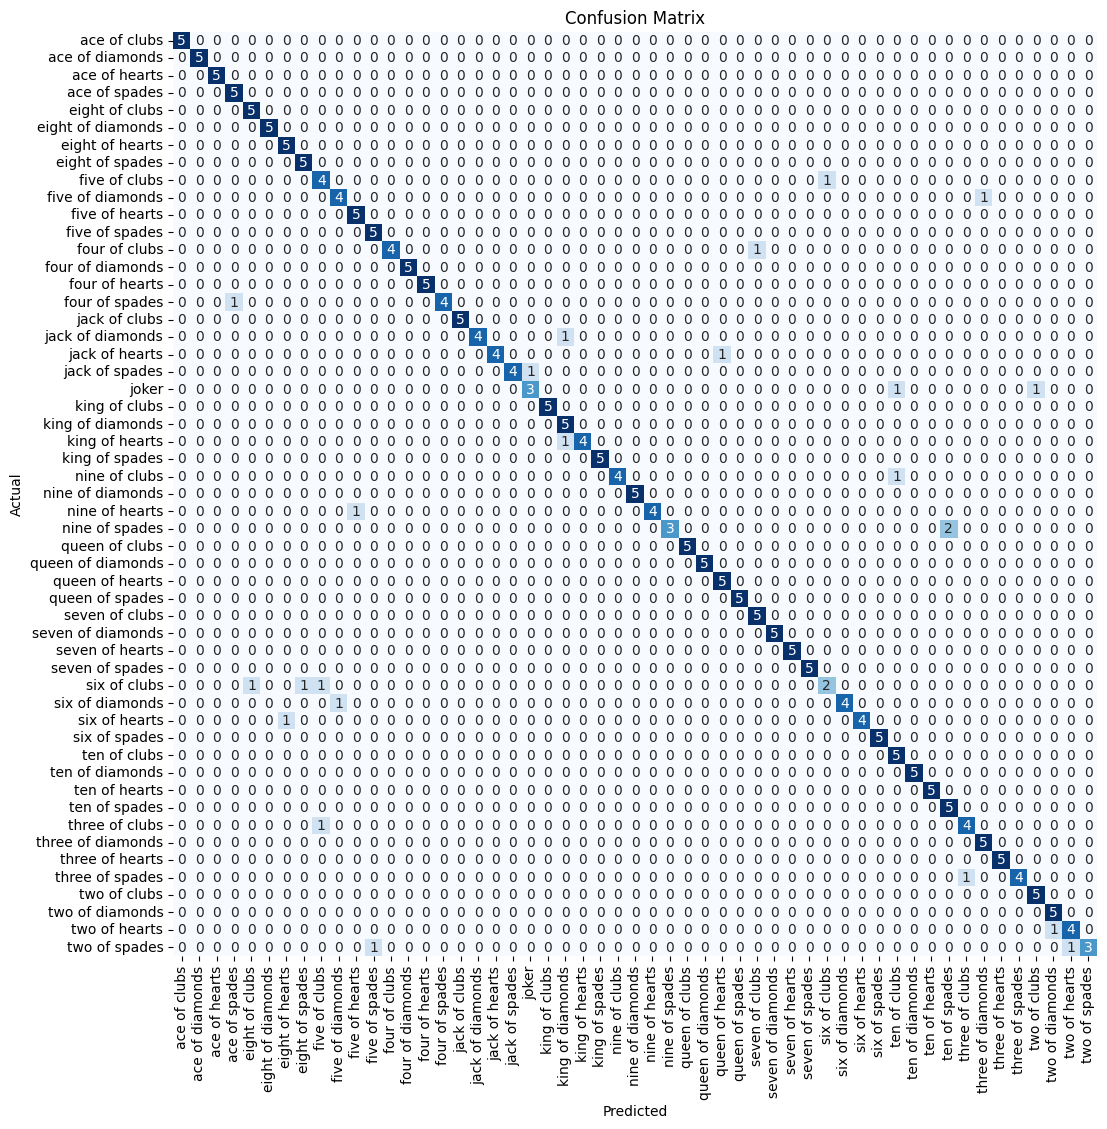

In [ ]:
show_matrix(transf2, test_dataset_ffd)

#Assignment

Objetivo: tratar de mejorar estos modelos

Grading: ranking proporcional al accuracy conseguido

Deadline:

Ideas:
- Ampliar la BD
- Usar los pesos y mejorar el DA, regularización, hiperparámetros, optimizadores, etc.
- Cambiar de arquitectura